In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import dense_diff_pool
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx, negative_sampling
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [5]:
dout='label-trick'

In [6]:
# gnn.config.set_gpu(False)

In [7]:
from torch_scatter import scatter_max
from torch_geometric.data import Batch


In [8]:
from utils.torchUtils.gnn import sample_pair
from utils.torchUtils import BaseTransform

In [9]:
class SampleCluster(BaseTransform):
    def __init__(self, n_pairs=5):
        super().__init__(n_pairs=n_pairs)
        self.n_pairs = n_pairs
    def __call__(self, data : Data) -> Data:
        arange = torch.arange(data.num_nodes)
        center = arange[torch.randint(data.num_nodes,(1,))]

        clusters = torch.combinations(arange, 4).T
        cluster_id = (data.node_id[clusters]+3)//4
        from_X = torch.all(cluster_id > 0,dim=0)
        from_Y = torch.all(cluster_id[0] == cluster_id[1:],dim=0)
        cluster_y = from_X & from_Y
        def _get_connected_clusters(cluster_idx):
            cluster_idx = clusters[:,cluster_idx]
            cluster_mask = (cluster_idx == center).any(dim=0)
            cluster_idx = cluster_idx[:, cluster_mask]
            return cluster_idx

        neg_clusters = torch.where(~cluster_y)[0]
        neg_clusters = _get_connected_clusters(neg_clusters)
        neg_clusters = neg_clusters[:, torch.randperm(neg_clusters.shape[1])[:self.n_pairs]]

        pos_clusters = neg_clusters[:,0]
        if cluster_y.sum() > 0:
            pos_clusters = torch.where(cluster_y)[0]
            pos_clusters = _get_connected_clusters(pos_clusters)
            if pos_clusters.shape[1] == 0:
                pos_clusters = torch.where(cluster_y)[0]
                pos_clusters = pos_clusters[torch.randint(pos_clusters.shape[0], (1,))]
                pos_clusters = clusters[:, pos_clusters]

        data.pos_index = pos_clusters.T.reshape(1, 4, -1)
        data.neg_index = neg_clusters.T.reshape(self.n_pairs, 4, -1)        
        return data

In [10]:
import utils.torchUtils as gnn 

# min_edge = gnn.min_edge_neighbor(n_neighbor=2, function=lambda f:f**2)
min_edge = gnn.min_edge_neighbor(n_neighbor=8, undirected=True)
# min_edge = gnn.min_edge_neighbor(n_neighbor=8, undirected=True, features=2, function=None)
# transform = gnn.Transform(gnn.SamplePair(n_pos=1, n_neg=5), min_edge)
# transform = gnn.Transform(SampleCenter(), min_edge)
transform = gnn.Transform(min_edge,SampleCluster())
template = gnn.Dataset('../data/template',make_template=True, transform=transform)

def load_training(fn='../data/MX_1000_MY_450-training', template=None):
    transform = template.transform
    dataset = gnn.Dataset(fn,transform=transform)[:9000]
    training, validation = gnn.train_test_split(dataset, 0.2)
    # training, validation = dataset[1800:], dataset[:1800]

    batch_size = 100
    trainloader = DataLoader(training, batch_size=batch_size, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return trainloader, validloader

def load_testing(fn='../data/MX_1000_MY_450-testing', template=None):
    transform = template.transform
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    # sample = [ data for data in sample if data.edge_y.sum() > 0 ]
    batch_size = 100
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)
trainloader, validloader  = load_training(template=template)

In [11]:
data = next( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:>)

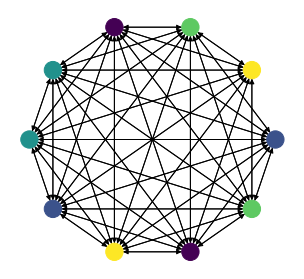

In [12]:
gnn.draw_data(data, data.edge_mask)

In [13]:
for batch in trainloader: break


In [14]:
# loss='mismatched_bjet_loss'
loss='std_loss'
model = gnn.modelMap['golden_cluster'](dataset=template, loss=loss)

In [15]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=5, gpus=1*gnn.config.ngpu)
trainer.fit(model, trainloader, validloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type             | Params
------------------------------------------------
0  | embed_1   | GCNLinear        | 832   
1  | conv_1    | GCNConvMask      | 12.4 K
2  | norm_1    | GCNBatchNorm     | 256   
3  | relu_1    | GCNRelu          | 0     
4  | embed_2   | GCNLinear        | 16.6 K
5  | conv_2    | GCNConvMask      | 49.3 K
6  | norm_2    | GCNBatchNorm     | 512   
7  | relu_2    | GCNRelu          | 0     
8  | cluster_1 | ClusterPredictor | 49.2 K
9  | relu_3    | ReLU             | 0     
10 | readout   | Sequential       | 3.2 K 
------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.529     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 90/90 [00:11<00:00,  7.85it/s, loss=1.85, v_num=1]


In [16]:
trainer.test(model, validloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing:  94%|█████████▍| 17/18 [00:02<00:00, 13.80it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hits/test': 0.38777777552604675,
 'loss/test': 1.84702730178833,
 'maxhits/test': 0.38777777552604675}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 18/18 [00:02<00:00,  6.13it/s]


[{'loss/test': 1.84702730178833,
  'hits/test': 0.38777777552604675,
  'maxhits/test': 0.38777777552604675}]

In [17]:
class predict_data(gnn.BaseTransform):
    def __init__(self, model=model):
        super().__init__()
        self.model = model
    def __call__(self, data : Data) -> Data:
        arange = torch.arange(data.num_nodes)
        clusters = torch.combinations(arange, 4)
        def predict_cluster(data, cluster):
            data = gnn.sample_cluster(data, cluster).to(self.model.device)
            return self.model.predict(data)
        cluster_o = torch.Tensor([predict_cluster(data, cluster) for cluster in clusters])
        min_o, max_o = cluster_o.min(), cluster_o.max()
        data.cluster_o = (cluster_o-min_o)/(max_o+min_o)
        data.rank_o = data.cluster_o.argsort(descending=True).argsort()
        cluster_id = (data.node_id[clusters.T]+3)//4
        from_X = torch.all(cluster_id > 0,dim=0)
        from_Y = torch.all(cluster_id[0] == cluster_id[1:],dim=0)
        data.cluster_y = 1*(from_X & from_Y)
        return data

In [18]:
def load_testing(fn='../data/MX_1000_MY_450-testing', template=None):
    transform = template.transform + predict_data() + gnn.to_uptri_graph()
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    batch_size = 100
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)

In [27]:
dataiter = iter( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10)

In [28]:
data = next(dataiter)

In [29]:
data

Data(x=[10, 6], edge_index=[2, 45], edge_attr=[45, 5], y=[10], edge_y=[45], node_id=[10], edge_id=[45], edge_d=[45], edge_mask=[45], pos_index=[1, 4, 1], neg_index=[5, 4, 1], labeled=[1], cluster_index=[4, 1], cluster_y=[210], cluster_o=[210], rank_o=[210])

(<Figure size 720x360 with 2 Axes>, <AxesSubplot:ylabel='Events'>)

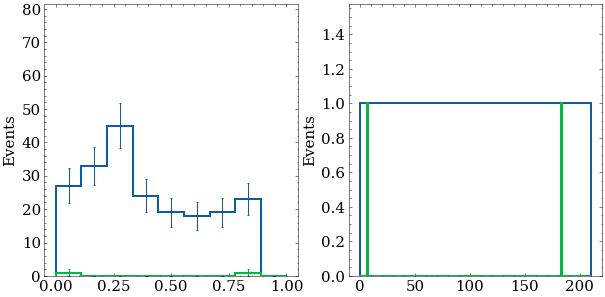

In [35]:
fig,ax=plt.subplots(ncols=2, figsize=(10,5))
hist_multi([data.cluster_o[data.cluster_y == 0], data.cluster_o[data.cluster_y==1]], bins=np.linspace(0,1,10),figax=(fig,ax[0]))
hist_multi([data.rank_o[data.cluster_y == 0], data.rank_o[data.cluster_y==1]], errors=None, figax=(fig,ax[1]))

In [23]:
# colmap = {True:[0,0,0], False:[1,0,0]}
# edge_color = torch.Tensor([ colmap[int(y)] for y in data.edge_mask ])

# gnn.draw_data(data, edge_labels=data.rank_o, edge_mask=data.rank_o<15, edge_color=edge_color)